In [2]:
# df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
# df_comments = df_comments.dropna(subset=['review_comment_message'])
# df_comments = df_comments.reset_index(drop=True)
# print(f'Dataset shape: {df_comments.shape}')
# df_comments.columns = ['score', 'comment']
# df_comments.head()

In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
#nltk.download()

# from text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, \
#     re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval

# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

import textdistance

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

import unicodedata

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [3]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-roa-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)




[]


In [4]:
src_text = ["Ola mundo!"]

model = MarianMTModel.from_pretrained(model_name)

translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))

tgt_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

In [8]:
tgt_text[0]

'Hello world!'

In [5]:
#Merging order data with review data
order_data = pd.read_csv("olist_order_items_dataset.csv")
review_data = pd.read_csv("olist_order_reviews_dataset.csv")

merged = review_data.merge(order_data, 'left', on='order_id')
# merged.head()

In [6]:
#Merging review data with product category
category_data = pd.read_csv('olist_products_dataset.csv')
merged2 = merged.merge(category_data, 'left', on='product_id')
# merged2.head()

In [7]:
#Final dataset with review_id, order_id, review scores/comments and product categories (both spanish and english)
translation_data = pd.read_csv('product_category_name_translation.csv')
product_review_data = merged2.merge(translation_data, 'left', on='product_category_name')
product_review_data

review_id                          order_id  \
0       7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1       7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
2       80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
3       228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
4       e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
...                                  ...                               ...   
113126  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
113127  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
113128  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
113129  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
113130  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

        review_score review_comment_title  \
0                  4                  NaN   
1                  4                  NaN   
2                  5                  NaN   
3                  5                  NaN   
4                  5                  NaN   
...              ...                  ...   
113126             5                  NaN   
113127             5                  NaN   
113128             5                  NaN   
113129             4                  NaN   
113130             1                  NaN   

                                   review_comment_message  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                   Recebi bem antes do prazo estipulado.   
...                                                   ...   
113126                                                NaN   
113127                                                NaN   
113128  Excelente mochila, entrega super rápida. Super...   
113129                                                NaN   
113130  meu produto chegou e ja tenho que devolver, po...   

       review_creation_date review_answer_timestamp  order_item_id  \
0       2018-01-18 00:00:00     2018-01-18 21:46:59            1.0   
1       2018-01-18 00:00:00     2018-01-18 21:46:59            2.0   
2       2018-03-10 00:00:00     2018-03-11 03:05:13            1.0   
3       2018-02-17 00:00:00     2018-02-18 14:36:24            1.0   
4       2017-04-21 00:00:00     2017-04-21 22:02:06            1.0   
...                     ...                     ...            ...   
113126  2018-07-07 00:00:00     2018-07-14 17:18:30            1.0   
113127  2017-12-09 00:00:00     2017-12-11 20:06:42            1.0   
113128  2018-03-22 00:00:00     2018-03-23 09:10:43            1.0   
113129  2018-07-01 00:00:00     2018-07-02 12:59:13            1.0   
113130  2017-07-03 00:00:00     2017-07-03 21:01:49            1.0   

                              product_id                         seller_id  \
0       fd25ab760bfbba13c198fa3b4f1a0cd3  6d803cb79cc31c41c4c789a75933b3c7   
1       fd25ab760bfbba13c198fa3b4f1a0cd3  6d803cb79cc31c41c4c789a75933b3c7   
2       be0dbdc3d67d55727a65d4cd696ca73c  8e6d7754bc7e0f22c96d255ebda59eba   
3       d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
4       52c80cedd4e90108bf4fa6a206ef6b03  a1043bafd471dff536d0c462352beb48   
...                                  ...                               ...   
113126  4fb209073dc2ab6a6d3c259a7c285501  5343d0649eca2a983820bfe93fc4d17e   
113127  3a33c980b62eb1ef3b8ae61b6fc6fe55  46dc3b2cc0980fb8ec44634e21d2718e   
113128  8ba0118a487ec8671aed57e5ef846574  17ca9b9e9b9ef8fdb529001b49ebb50f   
113129  73a7fbf8c1048131f3b531af31bcdf0e  8d956fec2e4337affcb520f56fd8cbfd   
113130  8fbd36d3b045f5f38b252b1513478f38  7e3f87d16fb353f408d467e74fbd8014   

        ... freight_value   product_catego

In [133]:
#translating comments
previous_run = pd.read_csv("translated_list.csv")
translated_comment = previous_run["0"].to_list()
#translated_comment = []
for i in range(len(translated_comment),len(product_review_data["review_comment_message"])):
    if i % 1000 == 0:
        df = pd.DataFrame(translated_comment)
        df.to_csv("translated_list.csv")
    print("iteration" + str(i), end='\r')
    if pd.isnull(product_review_data["review_comment_message"][i]):
        translated_comment.append(product_review_data["review_comment_message"][i])
        continue
    else:
        src_text = product_review_data["review_comment_message"][i]
        translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
        tgt_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
        translated_comment.append([tgt_text[0]])
        
# df = pd.DataFrame(translated_comment)
# df.to_csv("translated_list.csv")

In [166]:
product_review_full = product_review_data.head(len(translated_comment))
product_review_full['review_comment_message'] = translated_comment
product_review_full['review_comment_message'] = product_review_full['review_comment_message'][product_review_full['review_comment_message'].notna()].astype(str)
product_review_full.to_csv("translated_reviews.csv")

In [135]:
# creating dataframe
df = product_review_full

df[['review_score', 'review_comment_title', 'review_comment_message', 'product_category_name_english']].describe(include='all')

review_score review_comment_title review_comment_message  \
count   113131.000000                13523                  48166   
unique            NaN                 3679                  34307   
top               NaN            recomendo         ['Very good.']   
freq              NaN                 1027                    625   
mean         4.016998                  NaN                    NaN   
std          1.400074                  NaN                    NaN   
min          1.000000                  NaN                    NaN   
25%          4.000000                  NaN                    NaN   
50%          5.000000                  NaN                    NaN   
75%          5.000000                  NaN                    NaN   
max          5.000000                  NaN                    NaN   

       product_category_name_english  
count                         110750  
unique                            71  
top                   bed_bath_table  
freq                           11137  
mean                             NaN  
std                              NaN  
min                              NaN  
25%                              NaN  
50%                              NaN  
75%                              NaN  
max                              NaN

In [136]:
print('Comment titles')
print(df['review_comment_title'].value_counts().head())

print('\nScore distribution')
print(df['review_score'].value_counts())

Comment titles
recomendo          1027
super recomendo     696
ótimo               553
bom                 530
excelente           486
Name: review_comment_title, dtype: int64

Score distribution
5    63596
4    21348
1    14775
3     9476
2     3936
Name: review_score, dtype: int64


In [137]:
# data cleaning
df['review_comment_title'] = df['review_comment_title'].str.strip().str.lower()
df['product_category_name'] = df['product_category_name'].str.replace('_', ' ').str.lower()
# df['product_category_name'].value_counts().head(5)

In [138]:
# print('Score distribution')
# print(df['review_score'].value_counts() / len(df['review_score']))

# print('\nScore distribution split')
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# print(test_set['review_score'].value_counts() / len(df['review_score']))

print('\nScore distribution stratisfied split')
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['review_score']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
print(strat_train_set['review_score'].value_counts() / len(strat_train_set['review_score']))



Score distribution stratisfied split
5    0.562141
4    0.188699
1    0.130602
3    0.083764
2    0.034794
Name: review_score, dtype: float64


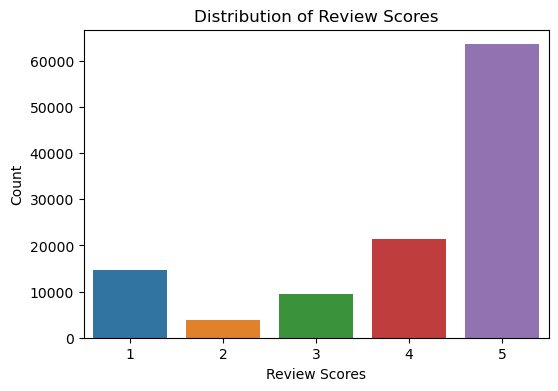

In [139]:
scores = df['review_score'].value_counts().reset_index()
scores.columns = ['review_scores', 'count']
plt.figure(figsize=(6, 4))
sns.barplot(x='review_scores', y='count', data=scores)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.show()

In [140]:
df['review_length'] = df['review_comment_message'].str.len()
df[['review_score', 'review_length', 'review_comment_message']].head()

review_score  review_length                  review_comment_message
0             4            NaN                                     NaN
1             4            NaN                                     NaN
2             5            NaN                                     NaN
3             5            NaN                                     NaN
4             5           38.0  ['I got it well before the deadline.']

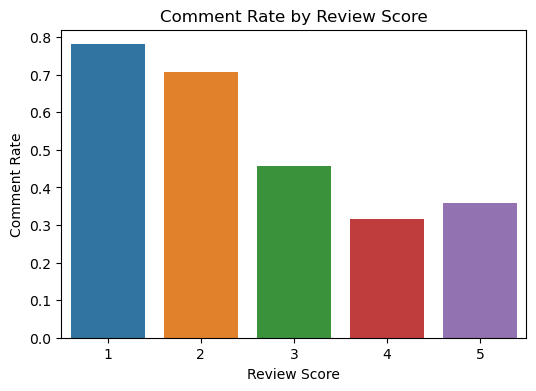

In [141]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = df.groupby('review_score').apply(comment_rate).reset_index()

comment_rates.columns = ['review_score', 'comment_rate']

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='review_score', y='comment_rate', data=comment_rates)
plt.xlabel('Review Score')
plt.ylabel('Comment Rate')
plt.title('Comment Rate by Review Score')
plt.show()

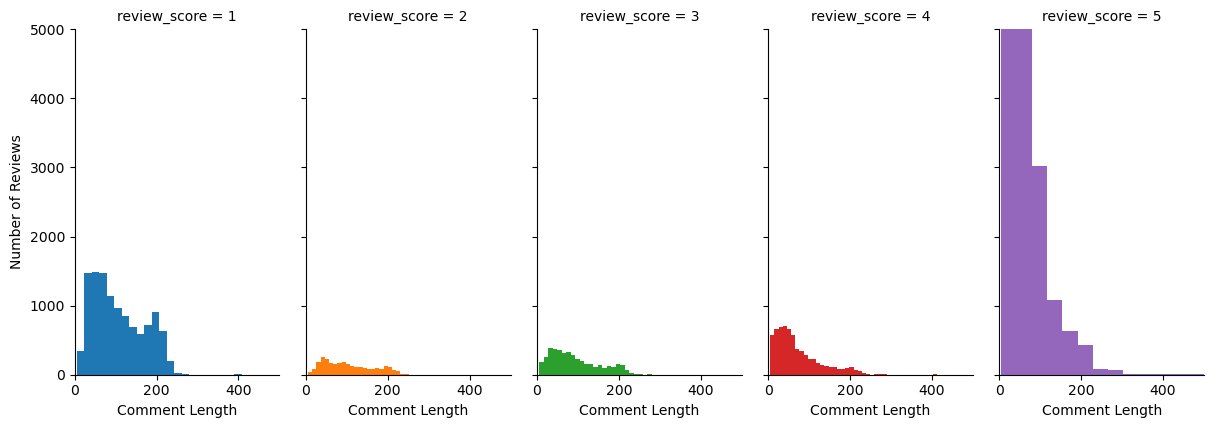

In [187]:
g = sns.FacetGrid(data=df, col='review_score', hue='review_score', xlim = (0, 500), ylim = (0, 5000))
g.map(plt.hist, 'review_length', bins=100)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

In [160]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('english'))
stop_list = ["good", "hey", "yeah", "beautiful", "great", "like", "love", "yes", "perfect","right","mt","kind","super","jewels","fine","oh","xxx","top","blah","dk","sorry","show","words","bad","store","okay","site","service","wrong","order", "xxxx","lights"]
for i in stop_list:
    STOP_WORDS.add(i) # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    plt.figure(figsize=(12, 5))
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color, )

In [161]:
commented_reviews = df[df['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

commented_reviews.head()

review_id                          order_id  \
4   e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
5   f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
13  8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   
20  4b49719c8a200003f700d3d986ea1a19  9d6f15f95d01e79bd1349cc208361f09   
24  3948b09f7c818e2d86c9a546758b2335  e51478e7e277a83743b6f9991dbfa3fb   

    review_score review_comment_title  \
4              5                  NaN   
5              5                  NaN   
13             4            recomendo   
20             4                  NaN   
24             5      super recomendo   

                               review_comment_message review_creation_date  \
4              ['I got it well before the deadline.']  2017-04-21 00:00:00   
5   ['Congratulations Lannister shops I love shopp...  2018-03-01 00:00:00   
13  ['efficient device. on the site the brand of t...  2018-05-22 00:00:00   
20  ['But a little, working... for the value of yo...  2018-02-16 00:00:00   
24  ['Reliable seller, product ok and delivery bef...  2018-05-23 00:00:00   

   review_answer_timestamp  order_item_id                        product_id  \
4      2017-04-21 22:02:06            1.0  52c80cedd4e90108bf4fa6a206ef6b03   
5      2018-03-02 10:26:53            1.0  3880d25d502b15b1de6fddc42ad1d67a   
13     2018-05-23 16:45:47            1.0  61a4100ccd6d9c4c808a1fd954ddb8ad   
20     2018-02-20 10:52:22            1.0  acffe5d7cd56e6b564cf6841486644ff   
24     2018-05-24 03:00:01            1.0  6871a3c157d6f51697e887f3c3598479   

                           seller_id  ... product_name_lenght  \
4   a1043bafd471dff536d0c462352beb48  ...                33.0   
5   989becdce12ebc39863c2bceab6f3ca1  ...                48.0   
13  05ff92fedb5be47920fea08e501238b9  ...                60.0   
20  db4350fd57ae30082dec7acbaacc17f9  ...                58.0   
24  974cf2cb8f4b7add98709c30df02fe10  ...                58.0   

    product_description_lenght  product_photos_qty product_weight_g  \
4                       2188.0                 2.0           7650.0   
5                        562.0                 5.0           9850.0   
13                      3839.0                 4.0           1450.0   
20                       356.0                 1.0            200.0   
24                      1923.0                 4.0            850.0   

    product_length_cm  product_height_cm  product_width_cm  \
4                20.0               20.0              20.0   
5               105.0               35.0              50.0   
13               24.0               24.0              24.0   
20               19.0                4.0              11.0   
24               25.0               11.0              15.0   

    product_category_name_english  review_length  \
4                    garden_tools           38.0   
5                  sports_leisure          128.0   
13               small_appliances          186.0   
20                  health_beauty           56.0   
24          computers_accessories           65.0   

                                 review_comment_words  
4                               (got, well, deadline)  
5   (lannister, shops, shopping, via, internet, sa...  
13  (device, brand, device, printed, disinfector, ...  
20                           (little, working, value)  
24          (seller, product, ok, delivery, deadline)  

[5 rows x 24 columns]

In [173]:
reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])



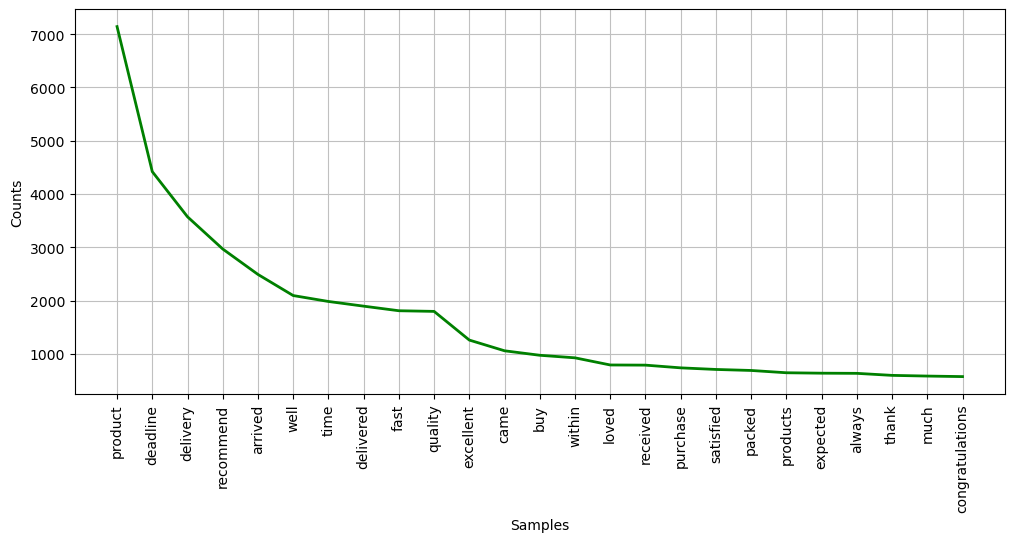

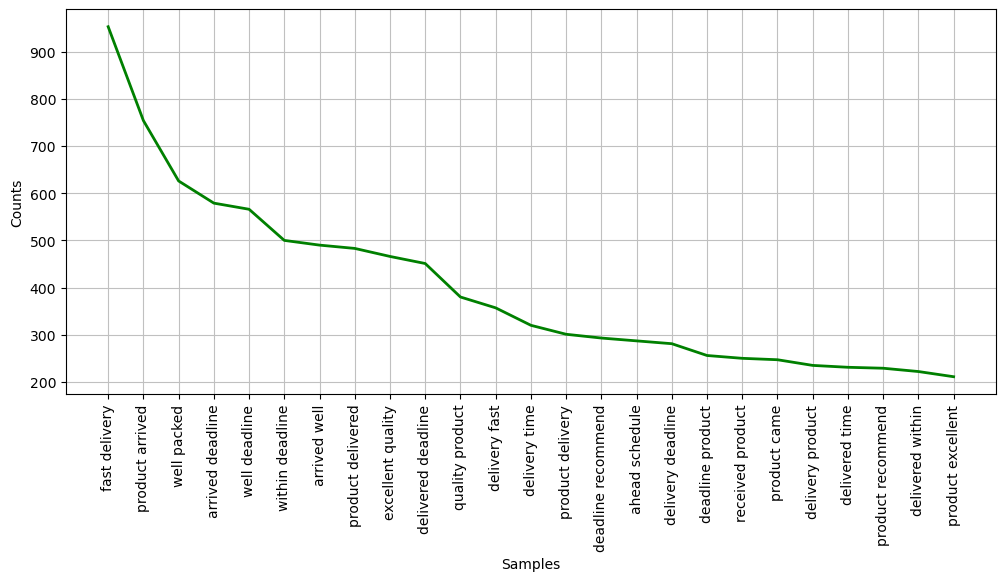

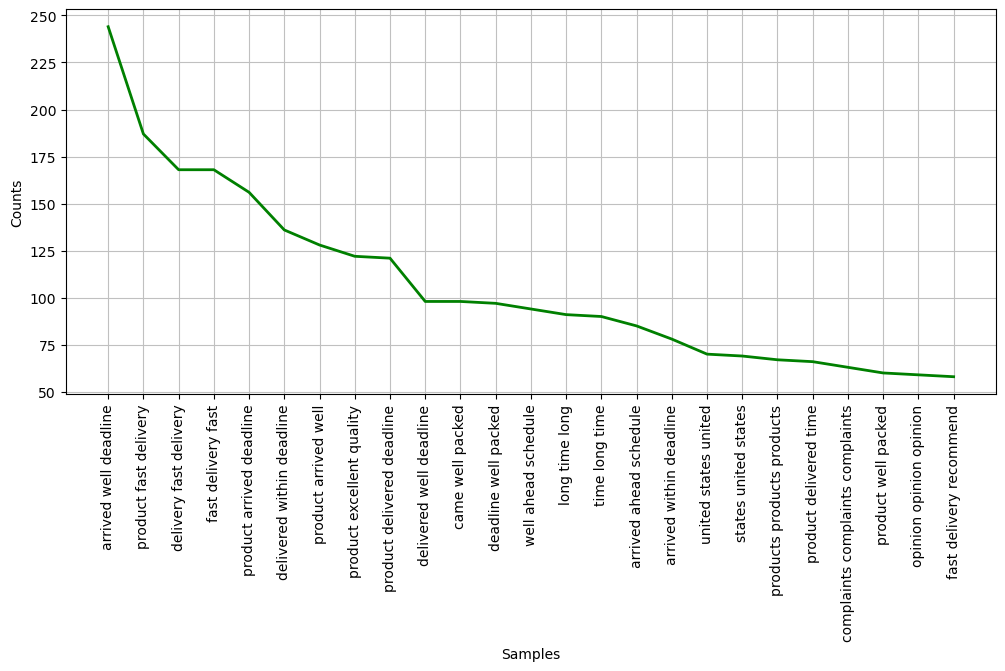

In [174]:
plot_freq(unigrams_5s, color='green')
plot_freq(bigrams_5s, color='green')
plot_freq(trigrams_5s, color='green')

In [175]:
def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)

WORDCLOUD_1S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]]
WORDCLOUD_5S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]]

def get_1s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_1S_PALETTE)

def get_5s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_5S_PALETTE)

def plot_wordcloud(words, style):
    if style == '1s':
        color_function = get_1s_color
        mask_fn = 'dislike.png'
        
    elif style == '5s':
        color_function = get_5s_color
        mask_fn = 'like.png'
        
    mask = np.array(Image.open(f'{mask_fn}'))[:, :, 3]
    mask_icon = mask == 0
    mask_bg = mask > 0
    mask[mask_icon] = 255
    mask[mask_bg] = 0
        
    wordcloud = WordCloud(background_color='white', mask=mask)
    wordcloud.generate(' '.join(words))
    wordcloud.recolor(color_func=color_function)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.gcf().set_size_inches(16, 10)

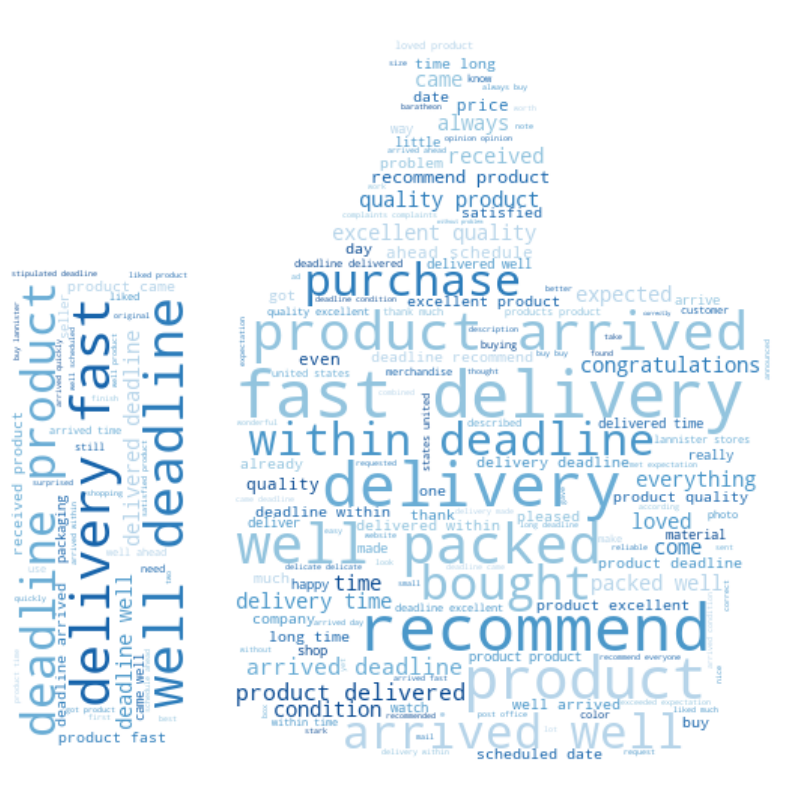

In [176]:
plot_wordcloud(trigrams_5s, '5s')

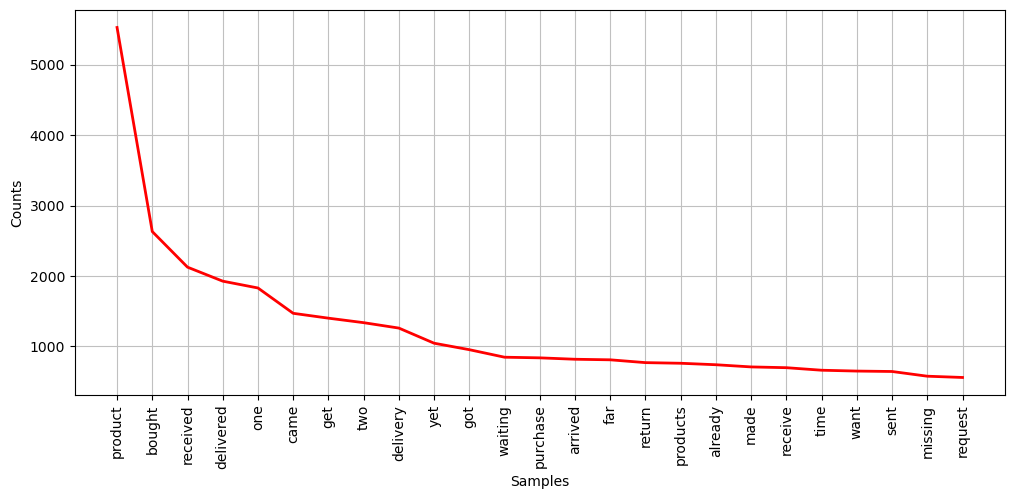

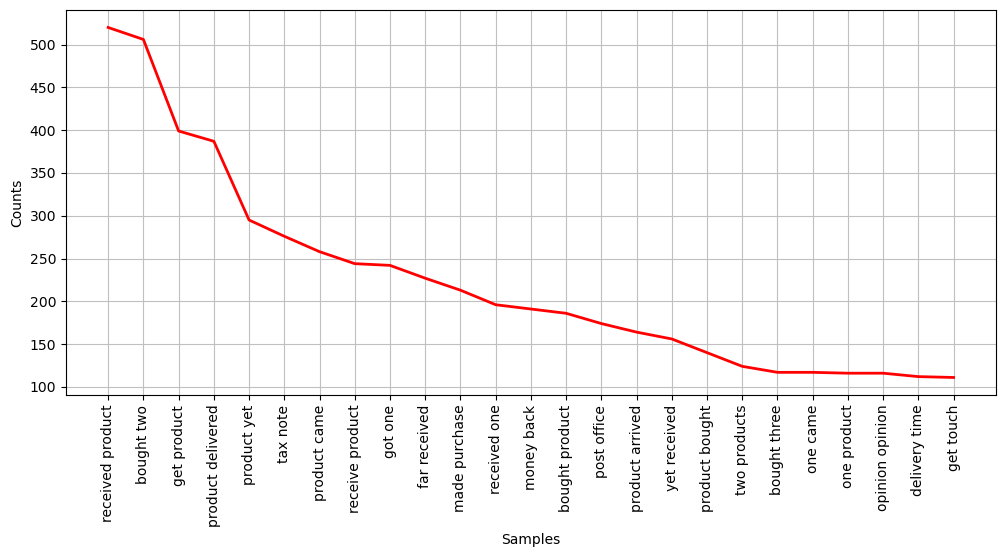

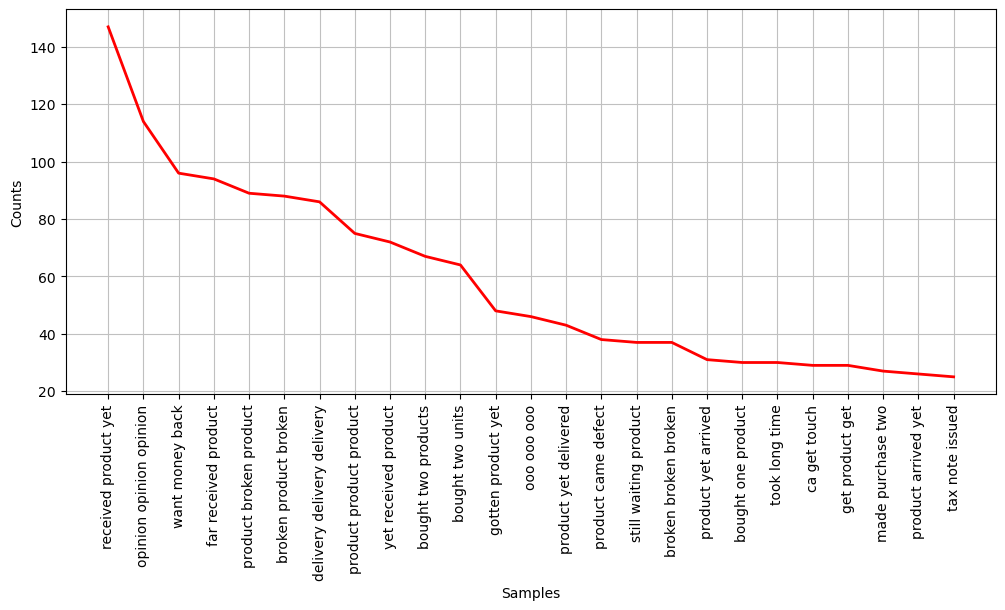

In [177]:
plot_freq(unigrams_1s, color='red')
plot_freq(bigrams_1s, color='red')
plot_freq(trigrams_1s, color='red')

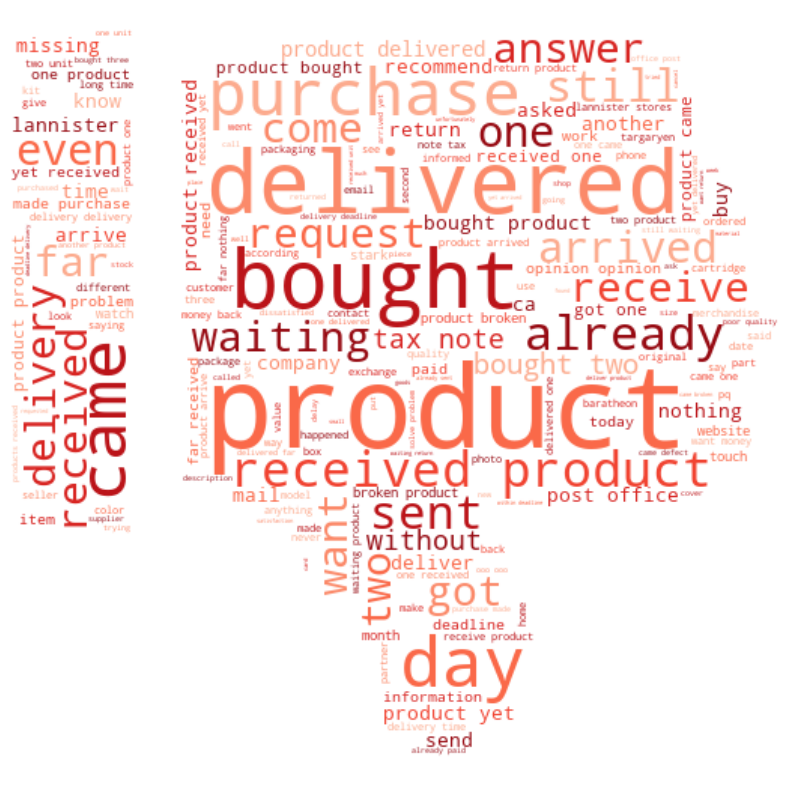

In [188]:
plot_wordcloud(trigrams_1s, '1s')

In [194]:
# commented_reviews['product_category_name_english'].unique()
commented_reviews['product_category_name_english'].value_counts()

product_category_name_english
bed_bath_table               5242
health_beauty                3751
furniture_decor              3578
sports_leisure               3438
computers_accessories        3290
                             ... 
fashion_sport                   7
la_cuisine                      6
cds_dvds_musicals               5
security_and_services           2
fashion_childrens_clothes       1
Name: count, Length: 71, dtype: int64

In [195]:
def n_gram_per_category(df):
    category_ngrams = {}

    for i in df['product_category_name_english'].unique():
        reviews_5s = df[(df['review_score'] == 5) & (df['product_category_name_english'] == i)]
        reviews_1s = df[(df['review_score'] == 1) & (df['product_category_name_english'] == i)]

        unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
        unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])
        category_ngrams[str(i)+'_5s'] = unigrams_5s, bigrams_5s, trigrams_5s
        category_ngrams[str(i)+'_1s'] = unigrams_1s, bigrams_1s, trigrams_1s

    return category_ngrams


In [196]:
n_gram_per_category(commented_reviews)


{'garden_tools_5s': (['recebi',
   'bem',
   'antes',
   'prazo',
   'estipulado',
   'ocorreu',
   'tudo',
   'contratado',
   'sendo',
   'entrega',
   'realizada',
   'antes',
   'prazo',
   'satisfeita',
   'parabens',
   'recebi',
   'antes',
   'prazo',
   'tudo',
   'correto',
   'combinado',
   'entrega',
   'rapida',
   'produto',
   'conforme',
   'anunciado',
   'bom',
   'produto',
   'entrega',
   'rapida',
   'recomendo',
   'gostei',
   'chegou',
   'tudo',
   'certinho',
   'antes',
   'prazo',
   'entrega',
   'atendeu',
   'expectivas',
   'mercadoria',
   'conforme',
   'pedido',
   'chegou',
   'antes',
   'prazo',
   'recomendo',
   'parabens',
   'loja',
   'lannister',
   'parceiro',
   'produto',
   'veio',
   'bem',
   'embalado',
   'mto',
   'lindo',
   'grande',
   'jeito',
   'queria',
   'cor',
   'marrom',
   'conforme',
   'mostra',
   'foto',
   'amei',
   'pendente',
   'produto',
   'igual',
   'anunciado',
   'super',
   'perfeitamente',
   'otima',


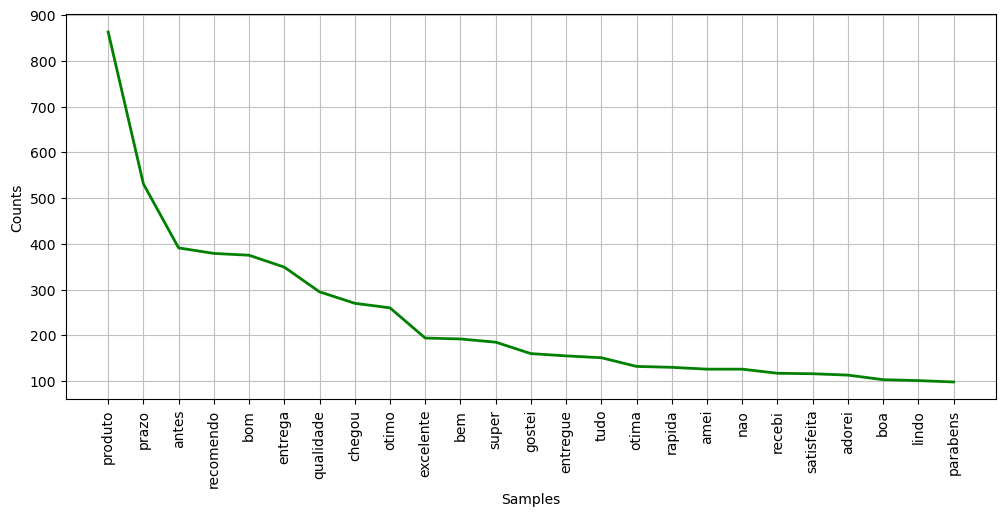

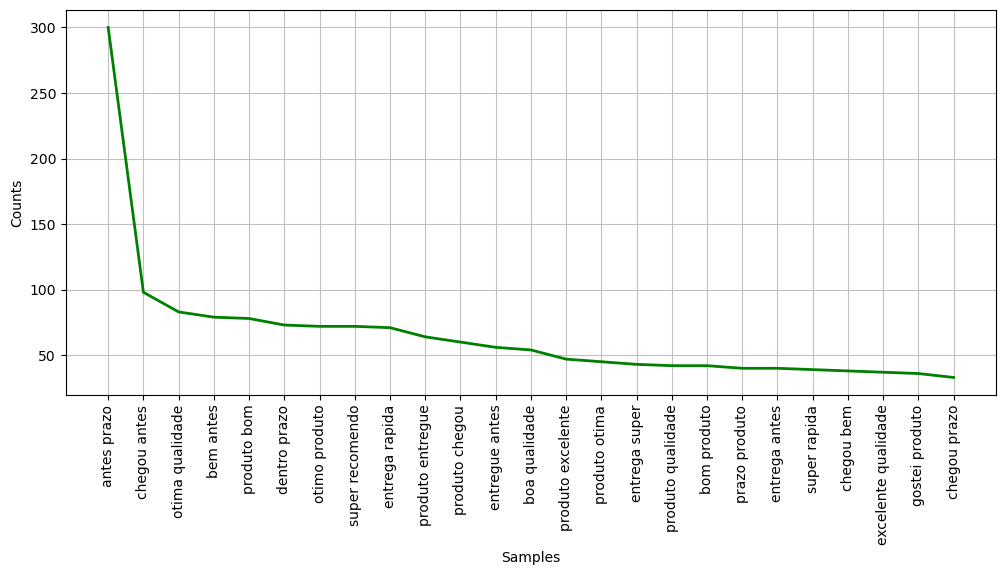

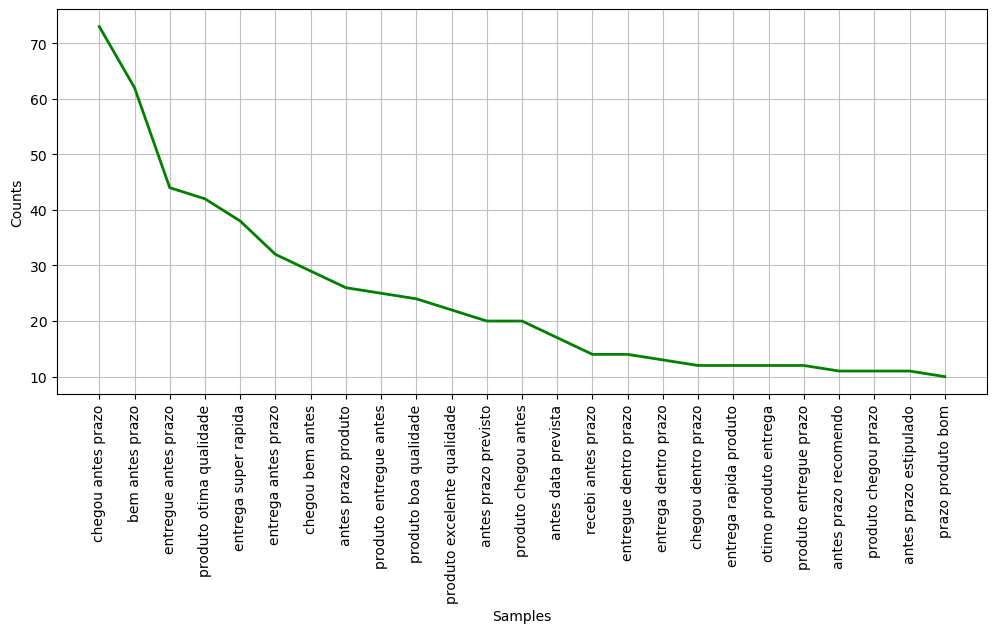

In [197]:
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_5s'][0], color='green')
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_5s'][1], color='green')
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_5s'][2], color='green')

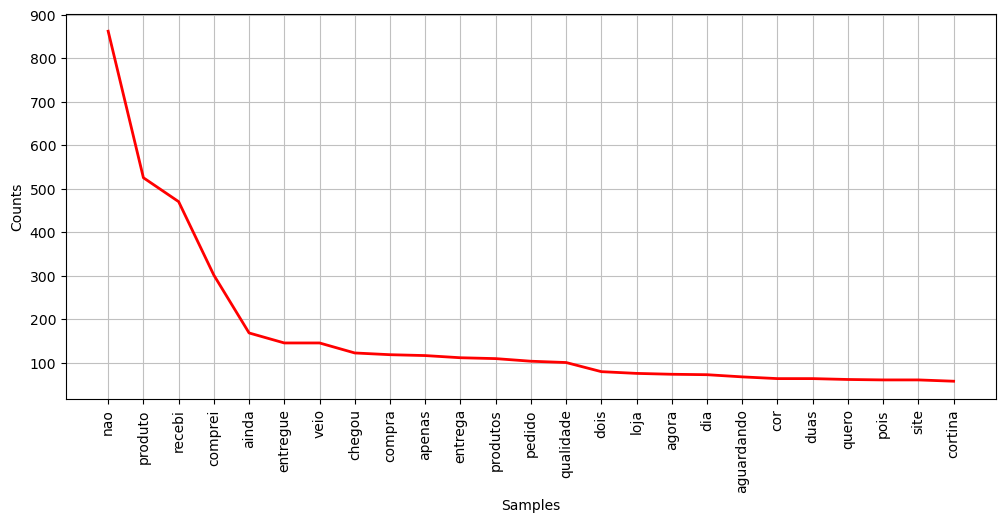

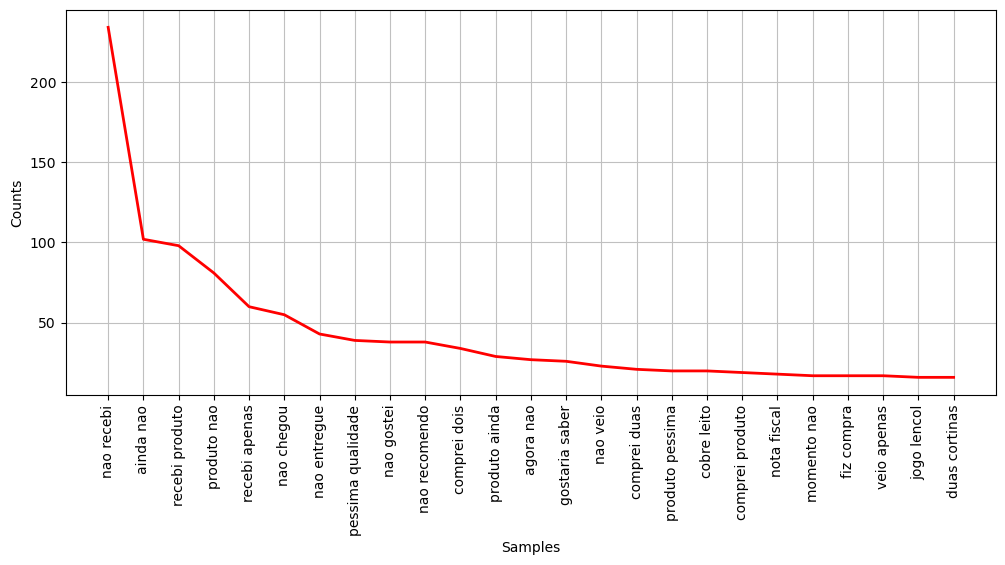

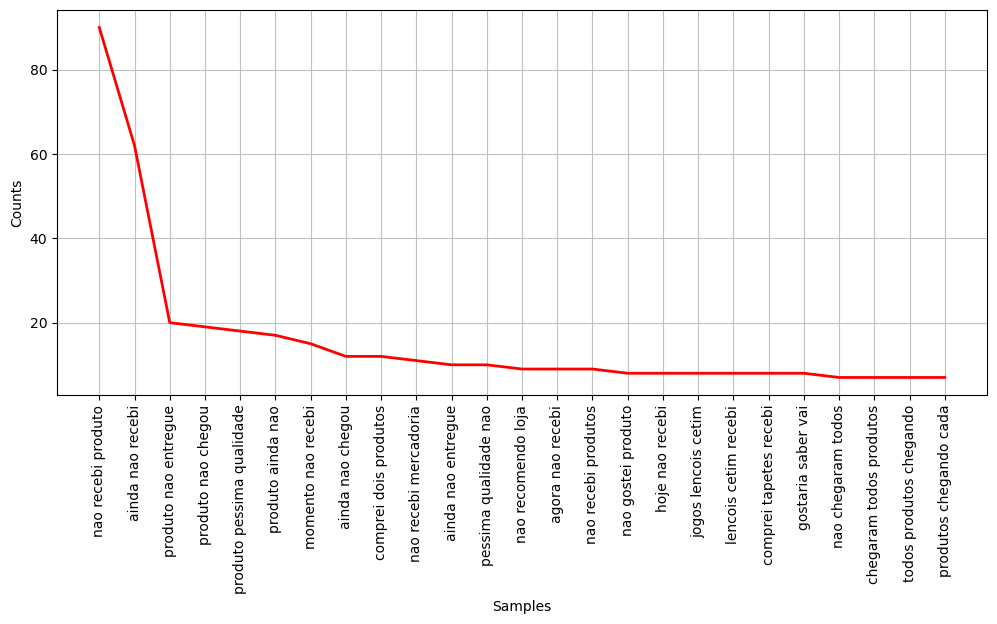

In [198]:
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_1s'][0], color='red')
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_1s'][1], color='red')
plot_freq(n_gram_per_category(commented_reviews)['bed_bath_table_1s'][2], color='red')

In [199]:
# Sample categories array
categories = [
    'garden_tools', 'sports_leisure', 'small_appliances',
    'health_beauty', 'computers_accessories', 'cool_stuff',
    'luggage_accessories', 'auto', 'electronics', 'watches_gifts',
    'bed_bath_table', 'pet_shop', 'perfumery', 'housewares',
    'furniture_decor', 'stationery', 'telephony', 'books_imported',
    'toys', 'baby', 'office_furniture', 'construction_tools_safety',
    'fashion_bags_accessories', 'art', 'computers',
    'christmas_supplies', 'home_appliances', 'audio', 'food_drink',
    'construction_tools_construction', 'industry_commerce_and_business',
    'musical_instruments', 'home_confort', 'market_place', 'drinks',
    'furniture_bedroom', 'signaling_and_security', 'home_construction',
    'cine_photo', 'air_conditioning', 'books_general_interest',
    'agro_industry_and_commerce', 'furniture_mattress_and_upholstery',
    'consoles_games', 'home_appliances_2', 'home_comfort_2', 'food',
    'fashion_underwear_beach', 'small_appliances_home_oven_and_coffee',
    'books_technical', 'construction_tools_lights', 'costruction_tools_tools',
    'music', 'fashion_male_clothing', 'fixed_telephony', 'costruction_tools_garden',
    'fashio_female_clothing', 'furniture_living_room', 'dvds_blu_ray',
    'fashion_shoes', 'cds_dvds_musicals', 'diapers_and_hygiene',
    'kitchen_dining_laundry_garden_furniture', 'party_supplies',
    'tablets_printing_image', 'flowers', 'la_cuisine', 'fashion_sport',
    'security_and_services', 'arts_and_craftmanship', 'fashion_childrens_clothes'
]

# categories = commented_reviews['product_category_name_english'].unique()

# Add product_category_cluster column to commented_reviews
def cluster_categories(category):
    if pd.isna(category):
        return np.nan
    if isinstance(category, float):
        return np.nan
    lev_distances = [textdistance.levenshtein.normalized_similarity(category, cat) for cat in categories]
    cluster_id = np.argmax(lev_distances)
    return cluster_id

commented_reviews['product_category_cluster'] = commented_reviews['product_category_name_english'].apply(cluster_categories)

# View the updated DataFrame
# commented_reviews.head()

In [200]:
commented_reviews.head()

review_id                          order_id  \
4   e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
5   f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
13  8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   
20  4b49719c8a200003f700d3d986ea1a19  9d6f15f95d01e79bd1349cc208361f09   
24  3948b09f7c818e2d86c9a546758b2335  e51478e7e277a83743b6f9991dbfa3fb   

    review_score review_comment_title  \
4              5                  NaN   
5              5                  NaN   
13             4            recomendo   
20             4                  NaN   
24             5      super recomendo   

                               review_comment_message review_creation_date  \
4               Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
5   Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
13  aparelho eficiente. no site a marca do aparelh...  2018-05-22 00:00:00   
20    Mas um pouco ,travando...pelo valor ta Boa.\r\n  2018-02-16 00:00:00   
24  Vendedor confiável, produto ok e entrega antes...  2018-05-23 00:00:00   

   review_answer_timestamp  order_item_id                        product_id  \
4      2017-04-21 22:02:06            1.0  52c80cedd4e90108bf4fa6a206ef6b03   
5      2018-03-02 10:26:53            1.0  3880d25d502b15b1de6fddc42ad1d67a   
13     2018-05-23 16:45:47            1.0  61a4100ccd6d9c4c808a1fd954ddb8ad   
20     2018-02-20 10:52:22            1.0  acffe5d7cd56e6b564cf6841486644ff   
24     2018-05-24 03:00:01            1.0  6871a3c157d6f51697e887f3c3598479   

                           seller_id  ... product_description_lenght  \
4   a1043bafd471dff536d0c462352beb48  ...                     2188.0   
5   989becdce12ebc39863c2bceab6f3ca1  ...                      562.0   
13  05ff92fedb5be47920fea08e501238b9  ...                     3839.0   
20  db4350fd57ae30082dec7acbaacc17f9  ...                      356.0   
24  974cf2cb8f4b7add98709c30df02fe10  ...                     1923.0   

    product_photos_qty  product_weight_g product_length_cm  product_height_cm  \
4                  2.0            7650.0              20.0               20.0   
5                  5.0            9850.0             105.0               35.0   
13                 4.0            1450.0              24.0               24.0   
20                 1.0             200.0              19.0                4.0   
24                 4.0             850.0              25.0               11.0   

    product_width_cm  product_category_name_english  review_length  \
4               20.0                   garden_tools           37.0   
5               50.0                 sports_leisure          100.0   
13              24.0               small_appliances          174.0   
20              11.0                  health_beauty           45.0   
24              15.0          computers_accessories           56.0   

                                 review_comment_words  \
4             (recebi, bem, antes, prazo, estipulado)   
5   (parabens, lojas, lannister, adorei, comprar, ...   
13  (aparelho, eficiente, site, marca, aparelho, i...   
20                  (pouco, travando, valor, ta, boa)   
24  (vendedor, confiavel, produto, ok, entrega, an...   

    product_category_cluster  
4                        0.0  
5                        1.0  
13                       2.0  
20                       3.0  
24                       4.0  

[5 rows x 25 columns]

In [201]:
print('clustered categories:', commented_reviews['product_category_cluster'].count())
print('regular categories:', commented_reviews['product_category_name_english'].count())

clustered categories: 46923
regular categories: 46923


In [202]:
# Handle NaN values
commented_reviews['product_category_name_english'].fillna('unknown_category', inplace=True)

# Fit label encoder
encoder = LabelEncoder()
encoder.fit(categories + ['unknown_category'])

# Encode categories in the DataFrame
commented_reviews['encoded_category'] = encoder.transform(commented_reviews['product_category_name_english'])

# Compute similarity matrix
similarity_matrix = np.zeros((len(categories) + 1, len(categories) + 1))
for i, cat1 in enumerate(categories + ['unknown_category']):
    for j, cat2 in enumerate(categories + ['unknown_category']):
        similarity_matrix[i, j] = textdistance.levenshtein.normalized_similarity(cat1, cat2)

# Hierarchical clustering with a set number of clusters
n_clusters = len(categories)
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
clusters = cluster.fit_predict(similarity_matrix)

# Assign clusters to DataFrame
commented_reviews['product_category_cluster'] = encoder.inverse_transform(clusters[commented_reviews['encoded_category']])

In [203]:
commented_reviews['product_category_cluster'].count()

48166